# Assignment 1. Data Manipulation and Visualization  

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For your questions refer to asoleix@gmail.com or @amirsoleix on Telegram*

### Description
In this homework you are supposed to get comfortable (or make sure that you are!) with the basic Python tools frequently used in data science.  

### Information  
Complete the information box below.

In [71]:
full_name = 'Ilia Hashemi Rad'
student_id = '99102456'

In [26]:
import warnings
warnings.filterwarnings("ignore")

# Import all your libraries here
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

## 1. Another LEGO brick in the wall
LEGO is a popular brand of toy building bricks. They are often sold in sets in order to build a specific object. Each set contains a number of parts in different shapes, sizes and colors. This database contains information on which parts are included in different LEGO sets. It was originally compiled to help people who owned some LEGO sets already figure out what other sets they could build with the pieces they had.

This dataset contains the official LEGO colors, parts, inventories (i.e., sets of LEGO parts which assembled create an object in the LEGO world) and sets (i.e., sets of LEGO inventories which assembled create a LEGO ecosystem). The schema of the dataset can be shown in the following diagram.

![lego-schema](lego-schema.png)

In this task you have to apply the following Data Wrangling pipeline:
* Load your data into `Pandas`  

* Explore it and clean its dirty parts
* Use it to answer a set of queries

Each of these subtasks are described in detail below.

### 1.1. Loading phase
Load all the csv files into different `DataFrames`. Use meaningful names for your `DataFrames` (e.g., the respective filenames).

In [20]:
# Specify the path to the 'lego' folder
folder_path = 'data\lego'

# Get a list of all the files in the 'lego' folder
files = os.listdir(folder_path)

# Filter for only the zip files
zip_files = [file for file in files if file.endswith('.zip')]

for zip_file in zip_files:
    # Construct the full path to the zip file
    zip_file_path = os.path.join(folder_path, zip_file)

    # Extract the CSV file from the zip archive
    with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
        # Assuming that there is only one CSV file in each zip
        csv_file_name = zip_file.namelist()[0]

        with zip_file.open(csv_file_name) as csv_file:
            # Read the CSV data into a DataFrame and create a variable with the same name
            df = pd.read_csv(csv_file)
            globals()[os.path.splitext(csv_file_name)[0]] = df

### 1.2. Cleaning phase
Explore the following columns from your dataset:

* sets: year  

* inventory_parts: quantity  
  
Answer the following questions using data visualizations and manipulations. The code for this part is required alongside your explanations either in comments or markdown.  
1. What is the time range of the sets?  

2. What is the average quantity of the inventory parts? 
3. Do you see any inconsistencies? 
4. Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset. 

#### sets: year:

As you can see below, according to the time range of the sets, which is from years about -20000 to 20000, we can understand that there is some inconsistencies in that. They are negative years which should be converted to positive and some values that are 5 digits instead of 4. But looking at them we realize that just the last digit of them has been replicated and the result is a 5 digit year. So, we can drop the last digit to reach the correct data. Also, we have some values like '70s' which indicate a decade that should be converted to the middle year of that decade.

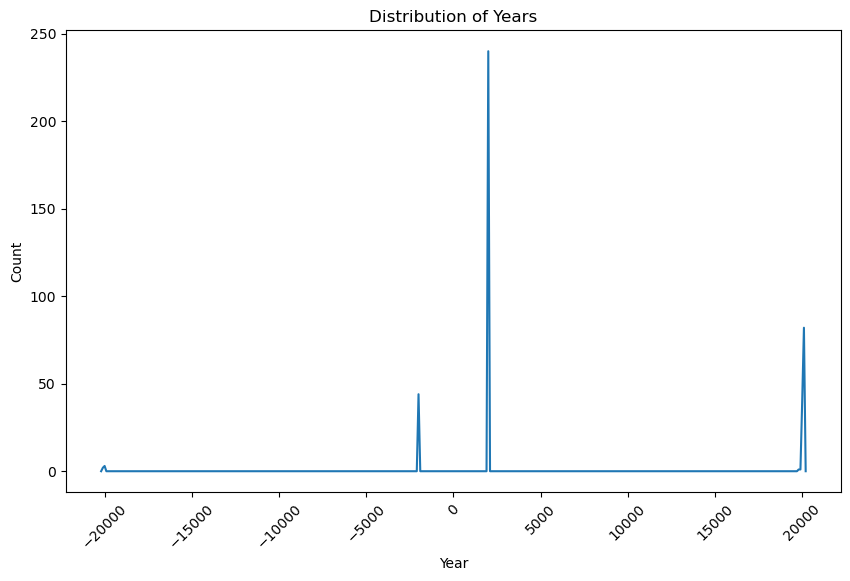

In [21]:
# Clean the 'year' column
def clean_year(x):
    try:
        return int(x)
    except (ValueError, TypeError):
        return None

sets2 = sets.copy()

sets2['year'] = sets2['year'].apply(clean_year)

# Drop rows with missing or non-integer values in the 'year' column
sets2 = sets2.dropna(subset=['year'])

# Convert the 'year' column to integer type
sets2['year'] = sets2['year'].astype(int)

# Calculate the minimum and maximum years
min_year = sets2['year'].min()
max_year = sets2['year'].max()

# Calculate the start and end years with a 100-year interval
start_year = ((min_year // 100) * 100)
end_year = ((max_year // 100) + 1) * 100

# Create a range of years with a 100-year interval
years_range = range(start_year, end_year + 100, 100)

# Create a line plot with a 100-year interval on the x-axis
year_counts = sets2['year'].value_counts().sort_index()
years = year_counts.index
counts = year_counts.values

# Create a new DataFrame with the range of years
new_df = pd.DataFrame(index=years_range)

# Fill the new DataFrame with the counts
new_df['counts'] = [counts[years.get_loc(year, method='ffill')] if year in years else 0 for year in years_range]

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(new_df.index, new_df['counts'])
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()

The cleaned data is as below. As I mentioned earlier, converting the decades to middle year of that decade(for example '70s' to 1975), dropping the last digit of 5 digit values and factoring the negative values to be corrected we have:

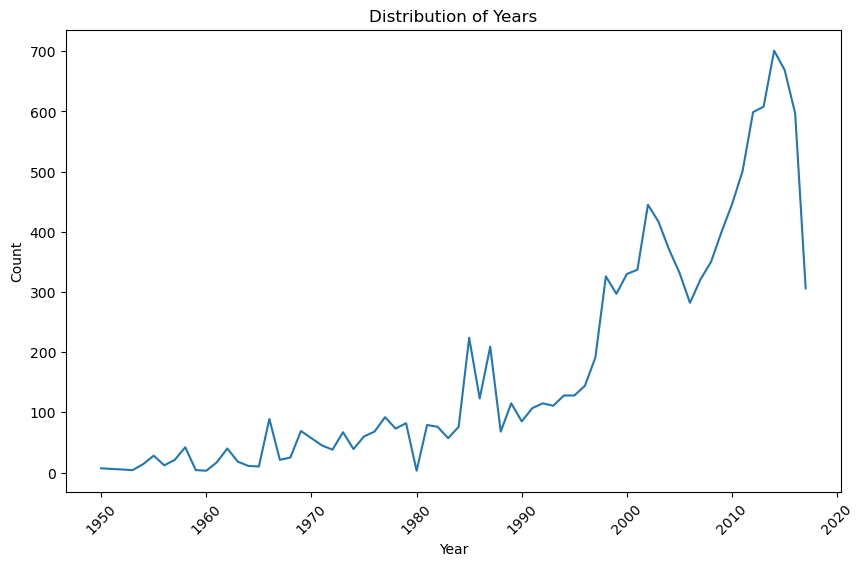

In [23]:
# Function to clean the 'year' values
def clean_year(x):
    if isinstance(x, str):
      if 's' in x:
        # Extract the decade and convert to a year in that decade
        return int('19' + x[:-2] + '5')
      else:
        x = int(x)  # Convert to integer
        if abs(x) > 9999:  # Check if it's a 5-digit value
            x = x // 10  # Drop the last digit
        return abs(x)  # Make the value positive
    else:
        return None

# Clean the 'year' column
sets['year'] = sets['year'].apply(clean_year)

# The 'year' column now contains cleaned values

# Create a line plot to visualize the time range
plt.figure(figsize=(10, 6))
plt.plot(sets['year'].value_counts().sort_index().index, sets['year'].value_counts().sort_index().values)
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()


As you see, the data is cleaned correclty as expected.
#### inventory_parts: quantity:

In this data, we see that the average is -inf that indicates being the -inf values in the data; which are inconsistencies.

Therefore, we drop the NaN and -Inf and Inf rows from the data and recalculate the mean which becomes about 3.8 that is correct.

In [24]:
# Determine the original average of the 'quantity' column
original_average = inventory_parts['quantity'].mean()

# Clean the 'quantity' column by replacing '-Inf' with NaN
inventory_parts['quantity'] = inventory_parts['quantity'][~inventory_parts['quantity'].isin([np.nan, np.inf, -np.inf])]
inventory_parts['quantity'] = inventory_parts['quantity'].dropna()

# Determine the new average after cleaning
new_average = inventory_parts['quantity'].mean()

# Print the original and new average
print(f"Original Average: {original_average}")
print(f"New Average after Cleaning: {new_average}")


Original Average: -inf
New Average after Cleaning: 3.836938260983857


### 1.3. Querying phase
Answer the following queries using the functionality of `Pandas`:

* List the IDs of the inventories that belong to sets that contain cars. (*Hint: Find a smart way to distinguish which sets contain cars based on the sets' name*).  

* Plot the distribution of part categories as a (horizontal) bar chart. Restrict yourself to the 20 largest part categories (in terms of the number of parts belonging to the category).  

* Find the dominant color of each set. Then, plot using a (horizontal) bar chart, the number of sets per dominant color. Color each bar with the respective color that it represents.  

* Create a scatter plot of the **luminance** of the sets vs their publishing year. After it is done, briefly answer the following questions:
  1. Do you see a trend over the last years?  
  
  2. How do you interpret it?

The luminance of a color is a [measure of brightness](https://en.wikipedia.org/wiki/Luminance) which, given its RGB representation, can be computed as follows:

$luminance = \sqrt{0.299*R^2 + 0.587*G^2 + 0.114*B^2}$

[500, 528, 908, 908, 1130, 1371, 1371, 1401, 1401, 1418, 1649, 1716, 1716, 1732, 2559, 2814, 2917, 3109, 3764, 4051, 4187, 4365, 4430, 4430, 4570, 4941, 4969, 5110, 5358, 5857, 5904, 5904, 6066, 6086, 6296, 6530, 7151, 7151, 7363, 7430, 7881, 7881, 8140, 8202, 8348, 8820, 8820, 8820, 8885, 9178, 9426, 9730, 10028, 10158, 10158, 10406, 10515, 10656, 11861, 11966, 11966, 12110, 12437, 12851, 12851, 13083, 13083, 13355, 13355, 13380, 13398, 13412, 13427, 13696, 13941, 14011, 14079, 14174, 14493, 14711, 14711, 14919, 15010, 15033, 15238, 15694, 16131]


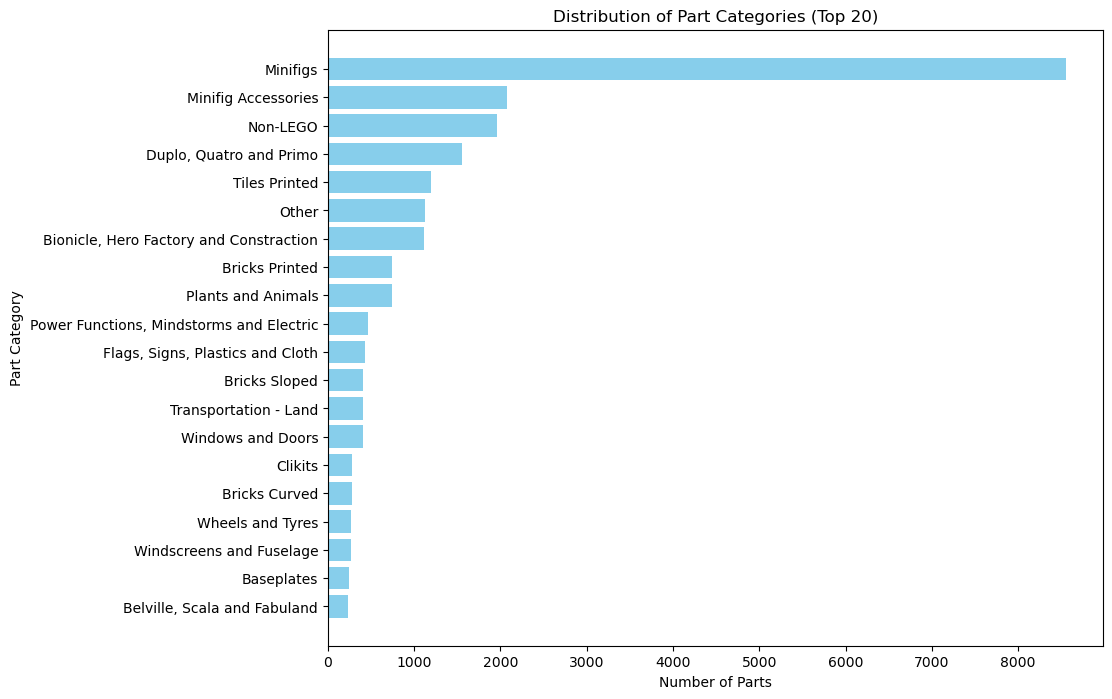

In [25]:
# first query
import re
# Define a regular expression pattern for car-related keywords with word boundaries
car_pattern = r'\b(?:car|auto|vehicle|automobile|hypercar)\b'

# Filter sets that contain cars based on keywords in their names
sets_with_cars = sets[sets['name'].str.contains(car_pattern, case=False, regex=True)]

# Get the IDs of the inventories that belong to sets with cars
inventory_ids_with_cars = inventory_sets[inventory_sets['set_id'].isin(sets_with_cars['id'])]['inventory_id']

# Display the list of inventory IDs that belong to sets with cars
print(inventory_ids_with_cars.tolist())




# second query
# First, we count the number of parts in each category
part_counts = parts['part_cat_id'].value_counts()

# Then, merge the part counts with the part categories DataFrame to get category names
category_counts = pd.merge(part_categories, part_counts, left_on='id', right_index=True)

# Sort the categories by the number of parts and take the top 20
top_20_categories = category_counts.nlargest(20, 'part_cat_id')

# Create the horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(top_20_categories['name'], top_20_categories['part_cat_id'], color='skyblue')
plt.xlabel('Number of Parts')
plt.ylabel('Part Category')
plt.title('Distribution of Part Categories (Top 20)')
plt.gca().invert_yaxis()  # Invert the y-axis to show the largest category at the top
plt.show()


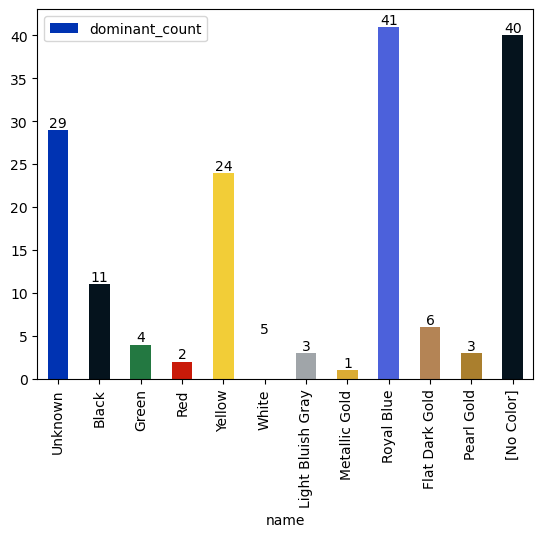

In [35]:
# third query
# Define a function to update the color inventory based on the row data
def update_color_inventory(row, color_inventory):
    # Create a temporary dictionary with the color ID and quantity
    temp = {row['color_id']: row['quantity']}

    # Check if the inventory ID is already in the color inventory
    if row['inventory_id'] not in color_inventory:
        # If not, add the temporary dictionary as the value for the inventory ID
        color_inventory[row['inventory_id']] = temp
    else:
        # If yes, check if the color ID is already in the nested dictionary
        if row['color_id'] not in color_inventory[row['inventory_id']]:
            # If not, add the color ID and quantity as a new key-value pair
            color_inventory[row['inventory_id']][row['color_id']] = row['quantity']
        else:
            # If yes, increment the quantity by the row quantity
            color_inventory[row['inventory_id']][row['color_id']] += row['quantity']

    # Return the updated color inventory
    return color_inventory

# Initialize an empty dictionary for the color inventory
color_inventory = {}

# Loop through each row in the inventory parts dataframe
for index, row in inventory_parts.iterrows():
    # Call the update_color_inventory function and assign the result to the color inventory
    color_inventory = update_color_inventory(row, color_inventory)

# Define a function to update the color sets based on the row data
def update_color_sets(row, color_sets, color_inventory, inventory_parts):
    # Check if the inventory ID is in the inventory parts dataframe
    if row['inventory_id'] in inventory_parts['inventory_id'].unique():
        # Get the nested dictionary for the inventory ID from the color inventory
        temp = color_inventory[row['inventory_id']]

        # Update the quantity values by multiplying them with the row quantity
        temp.update((x, y * row['quantity']) for x, y in temp.items())

        # Define a helper function to merge two dictionaries by adding their values
        def merge_dicts(dict1, dict2):
            return dict(Counter(dict1) + Counter(dict2))

        # Check if the set ID is already in the color sets
        if row['set_id'] not in color_sets:
            # If not, add the temporary dictionary as the value for the set ID
            color_sets[row['set_id']] = temp
        else:
            # If yes, merge the temporary dictionary with the existing one
            color_sets[row['set_id']] = merge_dicts(color_sets[row['set_id']], temp)

    # Return the updated color sets
    return color_sets

# Initialize an empty dictionary for the color sets
color_sets = {}

# Loop through each row in the inventory sets dataframe
for index, row in inventory_sets.iterrows():
    # Call the update_color_sets function and assign the result to the color sets
    color_sets = update_color_sets(row, color_sets, color_inventory, inventory_parts)

# Add a new column to the colors dataframe for the dominant count
colors["dominant_count"] = 0

# Initialize an empty dictionary for the result
result_dict = {}

# Loop through each set ID and color dictionary in the color sets
result_dict = {set_id: max(color_dict, key=color_dict.get) for set_id, color_dict in color_sets.items()}

# Initialize an empty dictionary for the result
result = {}

# Loop through each set ID and color ID in the result dictionary
for set_id, color_id in result_dict.items():
    # Check if the color ID is already in the result
    if color_id not in result:
        # If not, add the color ID and 1 as a new key-value pair
        result[color_id] = 1
    else:
        # If yes, increment the value by 1
        result[color_id] += 1

# Convert the result dictionary to a list of tuples
result = list(result.items())

# Loop through each color ID and dominant count in the result
for i in result:
    # Update the dominant_count column in the colors dataframe with the dominant count
    colors.loc[colors['id'] == i[0], 'dominant_count'] = i[1]

# Filter the colors dataframe to keep only the rows with non-zero dominant count
plot_colors = colors[colors['dominant_count'] != 0]

# Add a new column to the plot_colors dataframe with the RGB values
plot_colors['rgb_hex'] = '#' + plot_colors['rgb'].astype(str)

# Plot a horizontal bar chart of the dominant colors
# ... (Previous code)

# Plot a vertical bar chart of the dominant colors
ax = plot_colors.plot.bar(x='name', y='dominant_count', color=plot_colors['rgb_hex'])

# Add labels to the bars with the color ID
ax.bar_label(ax.containers[0], labels=plot_colors['dominant_count'])

# Show the plot
plt.show()

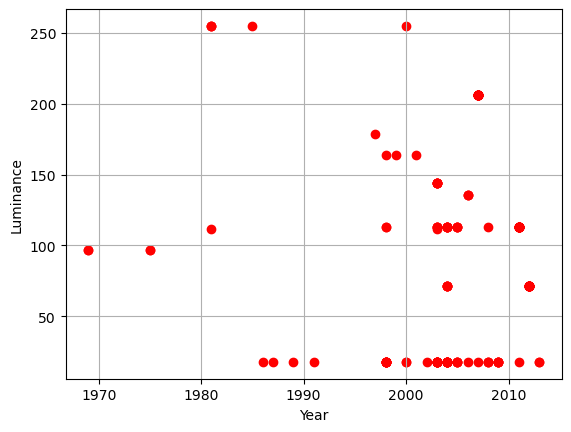

In [37]:
# forth query
# Initialize an empty dictionary to store luminance values for colors
luminance_dict = {}

# Iterate over each row in the 'colors' DataFrame
for index, row in colors.iterrows():
    # Extract the RGB values from the 'rgb' column and convert them to integers
    red = int(row['rgb'][0:2], base=16)
    green = int(row['rgb'][2:4], base=16)
    blue = int(row['rgb'][4:6], base=16)

    # Calculate the luminance using the formula for luminance
    luminance = np.sqrt(0.299 * red**2 + 0.587 * green**2 + 0.114 * blue**2)

    # If the 'id' of the color is not already in the dictionary, add it with its corresponding luminance
    if row['id'] not in luminance_dict:
        luminance_dict[row['id']] = luminance

# Replace the values in 'result_dict' with their corresponding luminance values from 'luminance_dict'
for key, value in result_dict.items():
    result_dict[key] = luminance_dict.get(value, value)

# Map the 'id' column in the 'sets' DataFrame to its corresponding luminance value in 'result_dict' and store it in a new column 'luminance'
sets['luminance'] = sets['id'].map(result_dict)

# Create a scatter plot of the year vs luminance with red color and grid lines
plt.scatter(sets['year'], sets['luminance'], color='red')
plt.xlabel('Year')
plt.ylabel('Luminance')
plt.grid(True)

# Display the plot
plt.show()


Of course, it is obvious that the luminance of the dominant colors of the sets has been increased during the time and now, in the last years, we have some more luminant sets than before in average.

## 2. Drop the bike

*Los Angeles Metro* has been sharing publicly [anonymized *Metro Bike Share* trip data](https://bikeshare.metro.net/about/data/) under the [Open Database License (ODbL)](http://opendatacommons.org/licenses/odbl/1.0/).

In this question you will again perform data wrangling and interpretation.

### 2.1. Loading phase
Load the json file into a `DataFrame`.


In [7]:
# Open the zipped file and read the JSON data
with zipfile.ZipFile('data/bikes/metro-bike-share-trip-data.json.zip', 'r') as archive:
    with archive.open('metro-bike-share-trip-data.json') as json_file:
        bikes = pd.read_json(json_file)

print(bikes.head())
NotCleaned_bikes = bikes.copy()

   Bike ID  Duration             End Time  Ending Station ID  \
0   6281.0       180  2016-07-07T04:20:00             3014.0   
1   6281.0      1980  2016-07-07T06:33:00             3014.0   
2   5861.0       300  2016-07-07T10:37:00             3016.0   
3   5861.0     10860  2016-07-07T13:38:00             3016.0   
4   6674.0       420  2016-07-07T12:58:00             3032.0   

   Ending Station Latitude  Ending Station Longitude Passholder Type  \
0                34.056610                -118.23721    Monthly Pass   
1                34.056610                -118.23721    Monthly Pass   
2                34.052898                -118.24156       Flex Pass   
3                34.052898                -118.24156       Flex Pass   
4                34.049889                -118.25588         Walk-up   

   Plan Duration           Start Time  Starting Station ID  \
0           30.0  2016-07-07T04:17:00               3014.0   
1           30.0  2016-07-07T06:00:00               3014.0

### 2.2. Cleaning phase

Perform the following actions on the dataset.

1. Describe the type and the value range of each attribute.  

2. Indicate and transform the attributes that are `Categorical`.
3. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)?
4. What are the possible pitfalls of having such columns?

Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.


#### Task 1: Describe the type and value range of each attribute

In [16]:
for col in bikes.columns:
    col_dtype = bikes[col].dtype
    col_min = bikes[col].min()
    col_max = bikes[col].max()
    print(f"{col}:\tType: {col_dtype}\tRange: {col_min}, {col_max}")

Bike ID:	Type: float64	Range: 1349.0, 6728.0
Duration:	Type: int64	Range: 60, 86400
End Time:	Type: object	Range: 2016-07-07T04:20:00, 2017-04-02T10:32:00
Ending Station ID:	Type: float64	Range: 3000.0, 4108.0
Ending Station Latitude:	Type: float64	Range: 0.0, 34.0642815
Ending Station Longitude:	Type: float64	Range: -118.472832, 0.0
Passholder Type:	Type: object	Range: Flex Pass, Walk-up
Plan Duration:	Type: float64	Range: 0.0, 365.0
Start Time:	Type: object	Range: 2016-07-07T04:17:00, 2017-03-31T23:45:00
Starting Station ID:	Type: float64	Range: 3000.0, 4108.0
Starting Station Latitude:	Type: float64	Range: 0.0, 34.0642815
Starting Station Longitude:	Type: float64	Range: -118.472832, 0.0
Trip ID:	Type: int64	Range: 1912818, 23794218
Trip Route Category:	Type: object	Range: One Way, Round Trip


#### Task 2: Transform datetime columns into datetime class

In [25]:
categorical_cols = bikes.select_dtypes(['object']).columns
print(f'Categorical columns: {categorical_cols}')

for col in categorical_cols:
    bikes[col] = pd.Categorical(bikes[col]).codes

Categorical columns: Index(['End Time', 'Passholder Type', 'Start Time', 'Trip Route Category'], dtype='object')


As you can see, the End Time and start Time are wrongly recognized categorical, So They should be at first converted to class and then the categorical attributes be detected.

In [8]:
date_cols = []

for col in bikes.columns:
    if pd.api.types.is_string_dtype(bikes[col]):
        try:
            bikes[col] = pd.to_datetime(bikes[col], format='%Y-%m-%dT%H:%M:%S')
            date_cols.append(col)
        except ValueError:
            pass

categorical_cols = bikes.select_dtypes(['object']).columns
print(f'Categorical columns: {categorical_cols}')

for col in categorical_cols:
    bikes[col] = pd.Categorical(bikes[col]).codes

Categorical columns: Index(['Passholder Type', 'Trip Route Category'], dtype='object')


#### Task 3 & 4:

In [9]:
# Step 1: Create a correlation matrix
corr_matrix = bikes.corr(numeric_only=True).abs()

# Step 2: Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Find columns with correlations greater than the specified threshold
redundant_cols = [column for column in upper.columns if any(upper[column] > 0.95)]

# Step 4: Drop redundant columns from the DataFrame
bikes.drop(redundant_cols, axis=1, inplace=True)

print("The reduced data redundancy dataframe")
bikes.info()

The reduced data redundancy dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132427 entries, 0 to 132426
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Bike ID                    132417 non-null  float64       
 1   Duration                   132427 non-null  int64         
 2   End Time                   132427 non-null  datetime64[ns]
 3   Ending Station ID          132331 non-null  float64       
 4   Ending Station Latitude    131376 non-null  float64       
 5   Passholder Type            132427 non-null  int8          
 6   Plan Duration              131661 non-null  float64       
 7   Start Time                 132427 non-null  datetime64[ns]
 8   Starting Station ID        132408 non-null  float64       
 9   Starting Station Latitude  132379 non-null  float64       
 10  Trip ID                    132427 non-null  int64         
 11  Trip Route Cat

In [59]:
print('The first dataframe that is not cleaned')
NotCleaned_bikes.info()


The first dataframe that is not cleaned
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132427 entries, 0 to 132426
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Bike ID                     132417 non-null  float64
 1   Duration                    132427 non-null  int64  
 2   End Time                    132427 non-null  object 
 3   Ending Station ID           132331 non-null  float64
 4   Ending Station Latitude     131376 non-null  float64
 5   Ending Station Longitude    131376 non-null  float64
 6   Passholder Type             132427 non-null  object 
 7   Plan Duration               131661 non-null  float64
 8   Start Time                  132427 non-null  object 
 9   Starting Station ID         132408 non-null  float64
 10  Starting Station Latitude   132379 non-null  float64
 11  Starting Station Longitude  132379 non-null  float64
 12  Trip ID                     1324

When a DataFrame has redundant columns, meaning that the information in one column can be derived from another, it can introduce various challenges:

1. **Multicollinearity**: Redundant columns can create multicollinearity, a condition where two or more columns are highly correlated. This can pose issues in machine learning models by making estimates unstable and results harder to interpret.

2. **Increased Complexity**: Redundant columns increase the dimensionality of your data. More dimensions can lead to overfitting in your models, where they perform exceptionally well on training data but poorly on unseen data.

3. **Inefficiency**: Redundant columns require extra computational resources for data processing and model training, which can slow down the overall process and increase memory usage.

4. **Confusion**: Having multiple columns conveying the same information can be confusing for data analysts, making it harder to understand and work with the dataset.

5. **Data Quality Issues**: If inconsistencies exist between redundant columns, it can result in data quality problems and difficulties in maintaining the dataset's integrity.

In light of these challenges, it's advisable to identify and remove redundant columns from our DataFrame. This can be achieved by analyzing the correlation between columns and eliminating those that exhibit high correlation or by using feature importance techniques in machine learning to select the most relevant columns for your specific analysis; Which became done in our code.



### 2.3. Querying phase
Answer the following queries using the functionality of `Pandas`.

* Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations).  

* Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*. What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.
* For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.
* Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.
* Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*. Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.

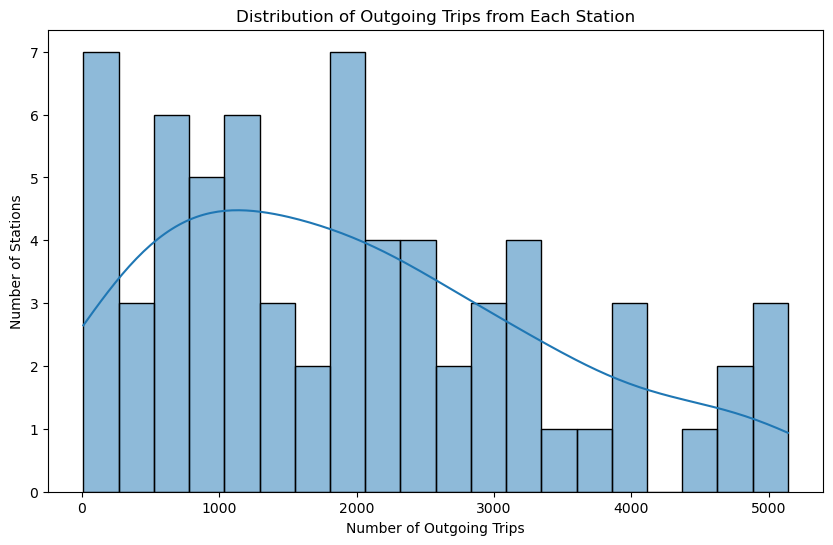

In [10]:
# Count the number of outgoing trips from each station
outgoing_counts = bikes['Starting Station ID'].value_counts()

# Create a histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(outgoing_counts, bins=20, kde=True)
plt.title('Distribution of Outgoing Trips from Each Station')
plt.xlabel('Number of Outgoing Trips')
plt.ylabel('Number of Stations')
plt.show()



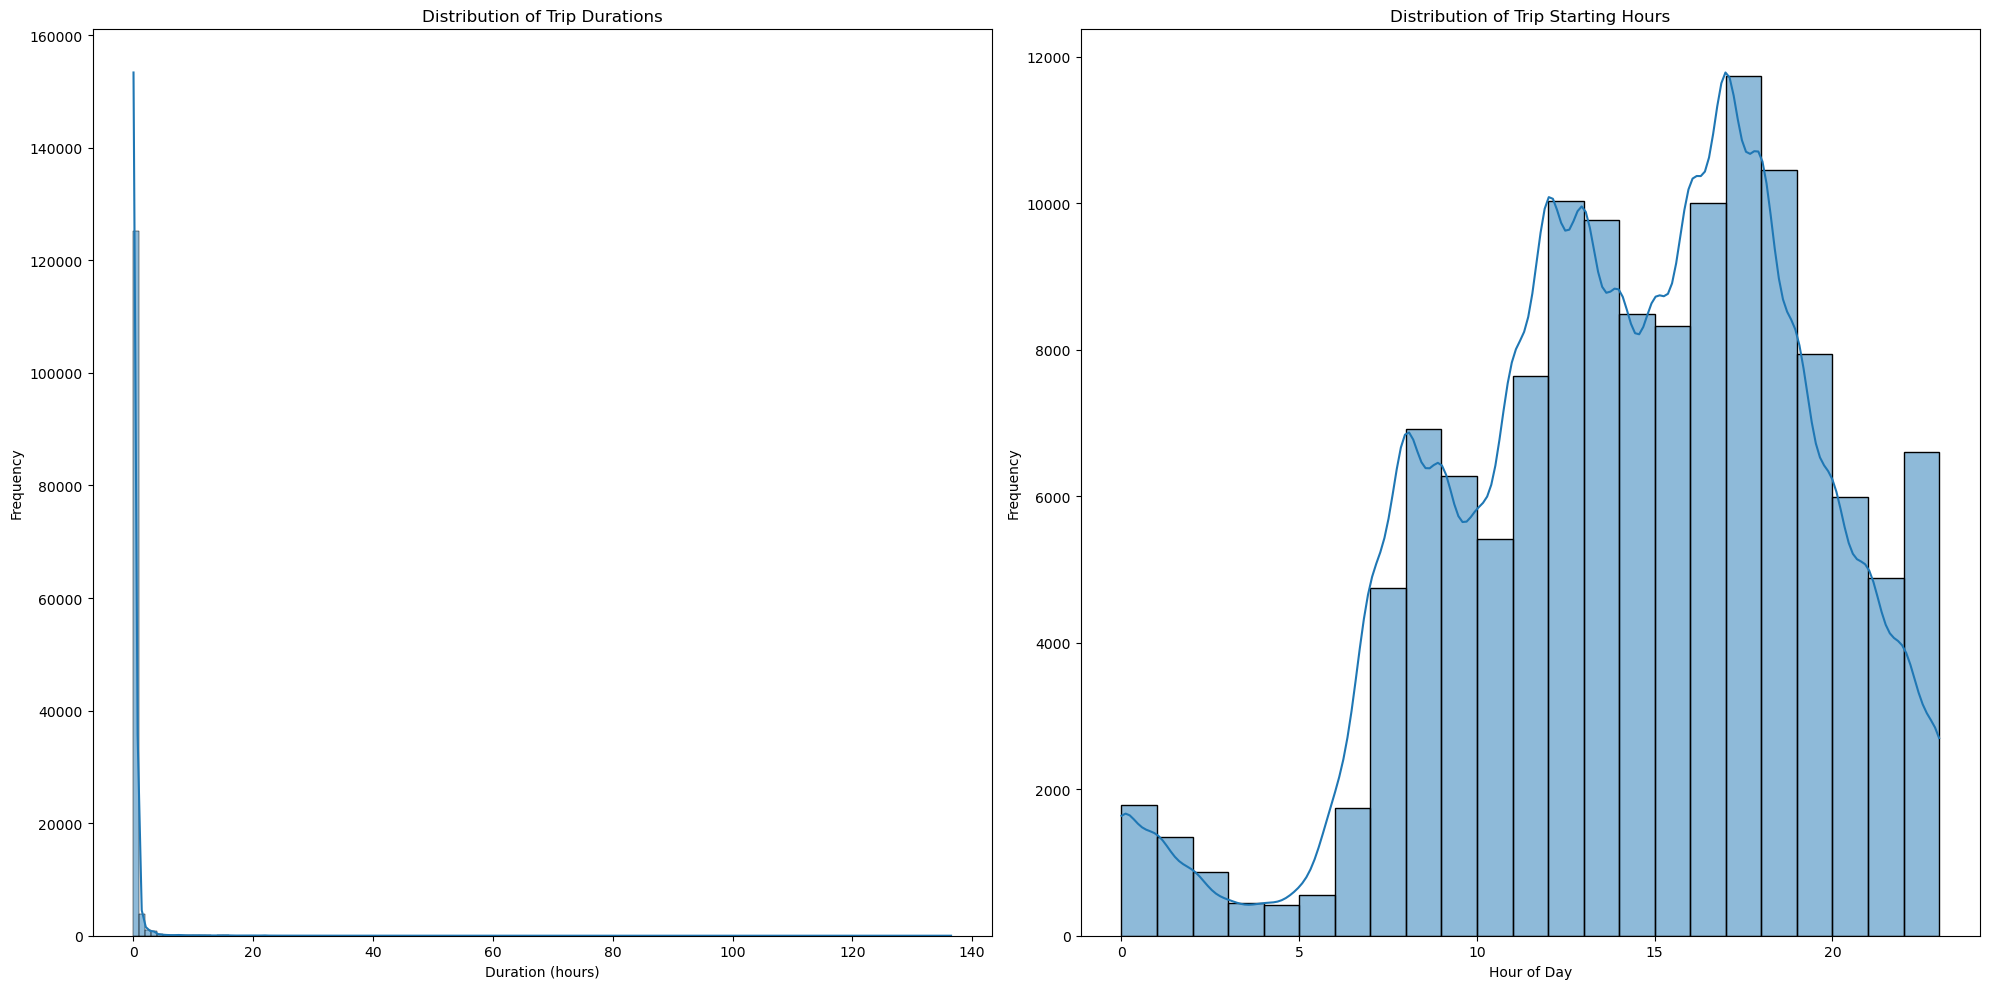

In [11]:
# Create a DataFrame for analysis
df = pd.DataFrame()
df['start_hour'] = bikes['Start Time'].dt.hour
df['duration'] = (bikes['End Time'] - bikes['Start Time']).dt.total_seconds() / 3600

# Create subplots for trip durations and starting hours
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot histogram for 'duration'
sns.histplot(df['duration'], bins=range(0, int(np.ceil(df['duration'].max())), 1), ax=axes[0], kde=True)
axes[0].set_title('Distribution of Trip Durations')
axes[0].set_xlabel('Duration (hours)')
axes[0].set_ylabel('Frequency')

# Plot histogram for 'start_hour'
sns.histplot(df['start_hour'], bins=range(0, 24, 1), ax=axes[1], kde=True)
axes[1].set_title('Distribution of Trip Starting Hours')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

It's evident from the data that most trips have a duration of less than an hour. This suggests that the majority of bike rides are relatively short in duration.

Additionally, the data reflects a human behavior pattern where there is a decrease in the number of trips starting as we approach the time around 5 AM. This decline is likely influenced by people's regular sleep patterns. Conversely, there is a noticeable peak in the number of trips starting at around 18:00 (6 PM). This can be attributed to the fact that this time of day aligns with when most people are awake and ready for outdoor activities and outings.

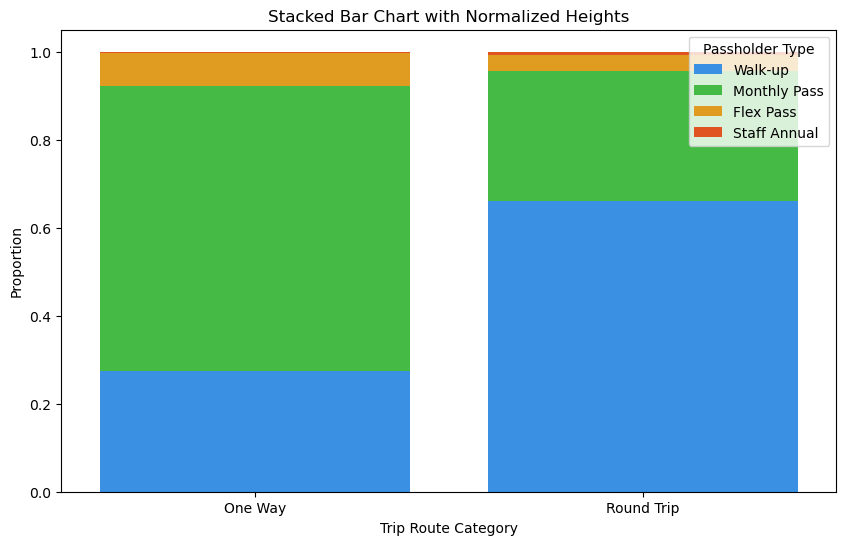

In [12]:
# Group the DataFrame by 'Trip Route Category' and 'Passholder Type', and calculate the size of each group
grouped = NotCleaned_bikes.groupby(['Trip Route Category', 'Passholder Type']).size().reset_index(name='Count')

# Pivot the data to have 'Passholder Type' as columns and normalize the values
pivot_table = grouped.pivot(index='Trip Route Category', columns='Passholder Type', values='Count')
normalized_table = pivot_table.div(pivot_table.sum(axis=1), axis=0)

# Create a stacked bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=normalized_table.reset_index(), x='Trip Route Category', y='Walk-up', label='Walk-up', color='dodgerblue')
sns.barplot(data=normalized_table.reset_index(), x='Trip Route Category', y='Monthly Pass', bottom=normalized_table['Walk-up'], label='Monthly Pass', color='limegreen')
sns.barplot(data=normalized_table.reset_index(), x='Trip Route Category', y='Flex Pass', bottom=normalized_table[['Walk-up', 'Monthly Pass']].sum(axis=1), label='Flex Pass', color='orange')
sns.barplot(data=normalized_table.reset_index(), x='Trip Route Category', y='Staff Annual', bottom=normalized_table[['Walk-up', 'Monthly Pass', 'Flex Pass']].sum(axis=1), label='Staff Annual', color='orangered')

plt.title('Stacked Bar Chart with Normalized Heights')
plt.xlabel('Trip Route Category')
plt.ylabel('Proportion')
plt.legend(title='Passholder Type', loc='upper right')
plt.show()

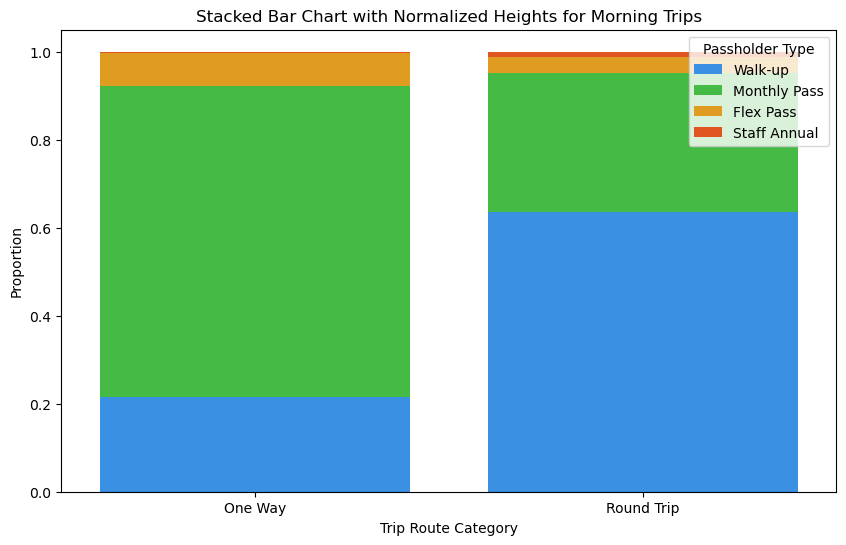

In [13]:
# Ensure 'Start Time' is of datetime data type
NotCleaned_bikes['Start Time'] = pd.to_datetime(NotCleaned_bikes['Start Time'])

# Filter the DataFrame to include trips that start before noon
morning_trips = NotCleaned_bikes[NotCleaned_bikes['Start Time'].dt.hour < 12]

# Group the DataFrame by 'Trip Route Category' and 'Passholder Type', and calculate the size of each group
grouped = morning_trips.groupby(['Trip Route Category', 'Passholder Type']).size().reset_index(name='Count')

# Calculate the proportion of trips within each 'Trip Route Category'
grouped['Proportion'] = grouped.groupby('Trip Route Category')['Count'].transform(lambda x: x / x.sum())

# Pivot the data to have 'Passholder Type' as columns and normalize the values
pivot_table = grouped.pivot(index='Trip Route Category', columns='Passholder Type', values='Proportion')
normalized_table = pivot_table.div(pivot_table.sum(axis=1), axis=0)

# Create a stacked bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=normalized_table.reset_index(), x='Trip Route Category', y='Walk-up', label='Walk-up', color='dodgerblue')
sns.barplot(data=normalized_table.reset_index(), x='Trip Route Category', y='Monthly Pass', bottom=normalized_table['Walk-up'], label='Monthly Pass', color='limegreen')
sns.barplot(data=normalized_table.reset_index(), x='Trip Route Category', y='Flex Pass', bottom=normalized_table[['Walk-up', 'Monthly Pass']].sum(axis=1), label='Flex Pass', color='orange')
sns.barplot(data=normalized_table.reset_index(), x='Trip Route Category', y='Staff Annual', bottom=normalized_table[['Walk-up', 'Monthly Pass', 'Flex Pass']].sum(axis=1), label='Staff Annual', color='orangered')

plt.title('Stacked Bar Chart with Normalized Heights for Morning Trips')
plt.xlabel('Trip Route Category')
plt.ylabel('Proportion')
plt.legend(title='Passholder Type', loc='upper right')
plt.show()

In [15]:
# Convert 'Start Time' to datetime format and extract the hour
import pandas as pd
import pandas as pd

# Convert 'Start Time' to datetime format and extract the hour
NotCleaned_bikes['start_hour'] = pd.to_datetime(NotCleaned_bikes['Start Time']).dt.hour

# Create two intervals for 'start_hour'
NotCleaned_bikes['hour_category'] = pd.cut(NotCleaned_bikes['start_hour'], bins=[-0.001, 14, 24], labels=[0, 1])

# Group the DataFrame by 'hour_category', 'Passholder Type', and 'Trip Route Category', and calculate the size of each group
grouped = NotCleaned_bikes.groupby(['hour_category', 'Passholder Type', 'Trip Route Category']).size().reset_index(name='Count')

# Calculate the proportion of trips within each hour interval
grouped['Proportion'] = grouped.groupby('hour_category')['Count'].transform(lambda x: x / x.sum())

# Normalize 'Proportion' across the entire DataFrame
total_proportion = grouped['Proportion'].sum()
grouped['Proportion'] = grouped['Proportion'] / total_proportion

grouped.drop(columns='Count', inplace=True)

grouped

,hour_category,Passholder Type,Trip Route Category,Proportion
0,0,Flex Pass,One Way,0.034741
1,0,Flex Pass,Round Trip,0.002016
2,0,Monthly Pass,One Way,0.296057
3,0,Monthly Pass,Round Trip,0.015547
4,0,Staff Annual,One Way,0.001376
5,0,Staff Annual,Round Trip,0.000444
6,0,Walk-up,One Way,0.118334
7,0,Walk-up,Round Trip,0.031485
8,1,Flex Pass,One Way,0.033472
9,1,Flex Pass,Round Trip,0.001630


In [17]:
# Calculate the proportion of travels in the first and second intervals
first_interval_proportion = grouped[grouped['hour_category'] == 0]['Proportion'].sum()
second_interval_proportion = grouped[grouped['hour_category'] == 1]['Proportion'].sum()

# Explain the proportion of travels in each interval
print(f"Proportion of travels in the first interval: {first_interval_proportion}", end="\t")
print(f"Proportion of travels in the second interval: {second_interval_proportion}")
print("This distribution aligns with our expectation since we designed the intervals to have nearly equal travel counts!")

# Calculate the proportion of first and second interval travels for Monthly Passholders
monthly_pass_first_interval_proportion = grouped[(grouped['hour_category'] == 0) & (grouped['Passholder Type'] == "Monthly Pass")]['Proportion'].sum()
monthly_pass_second_interval_proportion = grouped[(grouped['hour_category'] == 1) & (grouped['Passholder Type'] == "Monthly Pass")]['Proportion'].sum()

# Explain the proportion of Monthly Passholders' travels in each interval
print(f"Proportion of first interval travels for Monthly Passholders: {monthly_pass_first_interval_proportion}", end="\t")
print(f"Proportion of second interval travels for Monthly Passholders: {monthly_pass_second_interval_proportion}")
print("Interestingly, a larger portion of Monthly Passholders prefer to start their trips in the first interval, which suggests a potential impact on income.")

Proportion of travels in the first interval: 0.5	Proportion of travels in the second interval: 0.49999999999999994
This distribution aligns with our expectation since we designed the intervals to have nearly equal travel counts!
Proportion of first interval travels for Monthly Passholders: 0.31160401341817473	Proportion of second interval travels for Monthly Passholders: 0.3023123578468537
Interestingly, a larger portion of Monthly Passholders prefer to start their trips in the first interval, which suggests a potential impact on income.


## 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

**Run the following cell for a brief description about the dataset**

In [78]:
from IPython.core.display import HTML
HTML(filename='data'+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`.  
 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

             pclass     survived                  name   sex          age  \
count   1309.000000  1309.000000                  1309  1309  1046.000000   
unique          NaN          NaN                  1307     2          NaN   
top             NaN          NaN  Connolly, Miss. Kate  male          NaN   
freq            NaN          NaN                     2   843          NaN   
mean       2.294882     0.381971                   NaN   NaN    29.881135   
std        0.837836     0.486055                   NaN   NaN    14.413500   
min        1.000000     0.000000                   NaN   NaN     0.166700   
25%        2.000000     0.000000                   NaN   NaN    21.000000   
50%        3.000000     0.000000                   NaN   NaN    28.000000   
75%        3.000000     1.000000                   NaN   NaN    39.000000   
max        3.000000     1.000000                   NaN   NaN    80.000000   

              sibsp        parch    ticket         fare        cabin embark

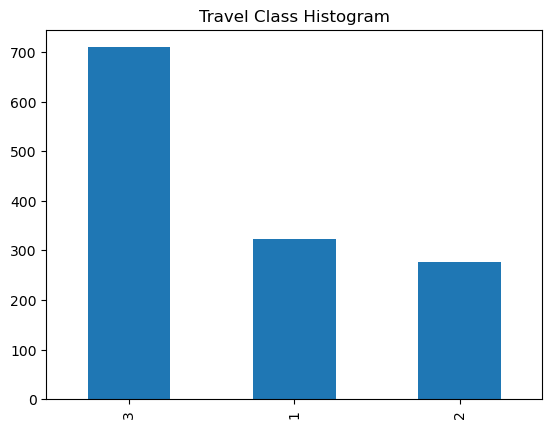

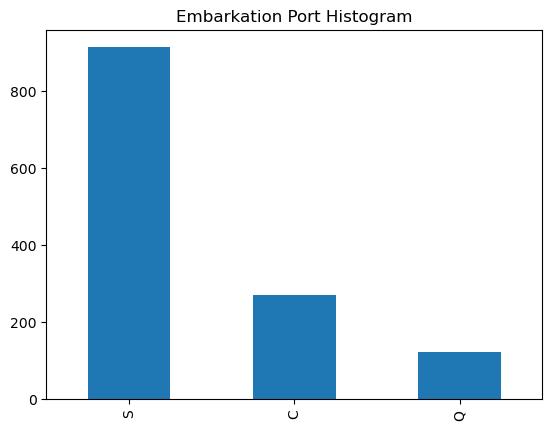

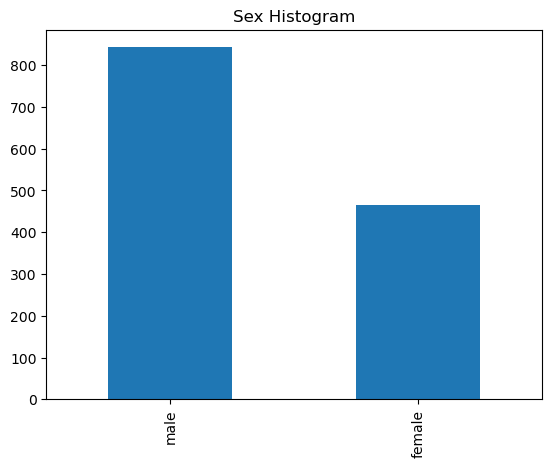

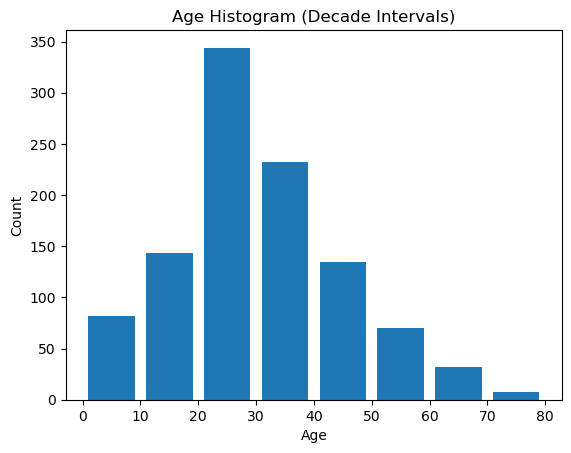

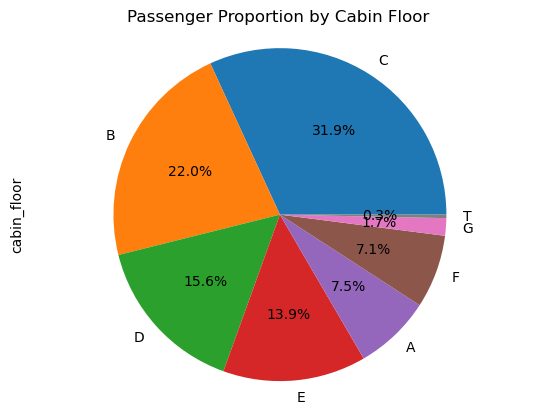

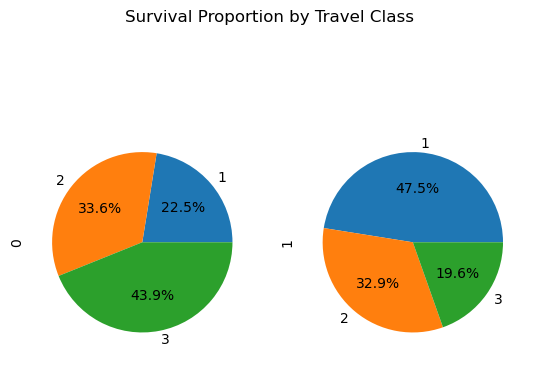

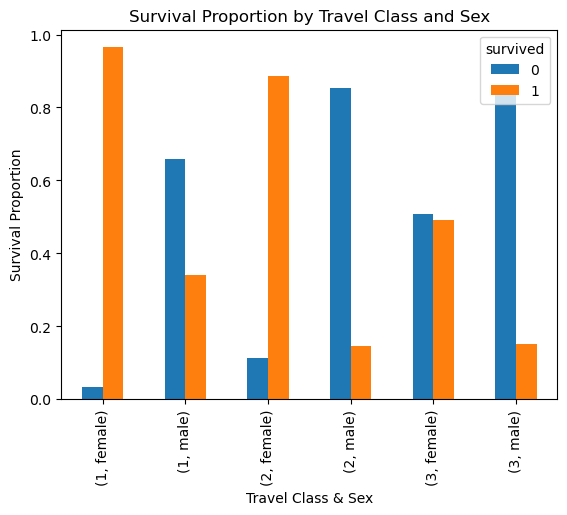

survived                            0         1
age           pclass sex                       
(0.166, 28.0] 1      female  0.048780  0.951220
                     male    0.468750  0.531250
              2      female  0.089286  0.910714
                     male    0.783784  0.216216
              3      female  0.486239  0.513761
                     male    0.816964  0.183036
(28.0, 80.0]  1      female  0.032609  0.967391
                     male    0.697479  0.302521
              2      female  0.127660  0.872340
                     male    0.916667  0.083333
              3      female  0.627907  0.372093
                     male    0.856000  0.144000


In [79]:
# Specify the path to the Excel file
excel_file_path = 'data/titanic.xls'

# Use the read_excel function to read the data
titanic_data = pd.read_excel(excel_file_path)

titanic_data.columns = ['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']

# 1. Describe the type and value range of each attribute
attribute_info = titanic_data.describe(include='all')
print(attribute_info)

# Transformation for Categorical Attributes
categorical_attributes = ['pclass', 'sex', 'embarked']
for col in categorical_attributes:
    titanic_data[col] = titanic_data[col].astype('category')

# 2. Plot histograms
# Plotting histogram for travel class (pclass)
titanic_data['pclass'].value_counts().plot(kind='bar', title='Travel Class Histogram')
plt.show()

# Plotting histogram for embarkation port (embarked)
titanic_data['embarked'].value_counts().plot(kind='bar', title='Embarkation Port Histogram')
plt.show()

# Plotting histogram for sex
titanic_data['sex'].value_counts().plot(kind='bar', title='Sex Histogram')
plt.show()

# Plotting histogram for age in discrete decade intervals
titanic_data['age'].plot.hist(bins=range(0, 90, 10), rwidth=0.8, title='Age Histogram (Decade Intervals)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 3. Calculate the proportion of passengers by cabin floor and present in a pie chart
# Extract the cabin floor (first character of the Cabin column)
titanic_data['cabin_floor'] = titanic_data['cabin'].str[0]
cabin_floor_proportions = titanic_data['cabin_floor'].value_counts(normalize=True)
cabin_floor_proportions.plot.pie(title='Passenger Proportion by Cabin Floor', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

# 4. Calculate the proportion of passengers that survived by travel class and present in pie charts
survival_proportions_by_class = titanic_data.groupby('pclass')['survived'].value_counts(normalize=True)
survival_proportions_by_class.unstack().plot(kind='pie', subplots=True, autopct='%1.1f%%', legend=False)
plt.suptitle('Survival Proportion by Travel Class')
plt.show()

# 5. Calculate the proportion of passengers that survived by travel class and sex, and present in a single histogram
survival_proportions_by_class_sex = titanic_data.groupby(['pclass', 'sex'])['survived'].value_counts(normalize=True)
survival_proportions_by_class_sex.unstack().plot(kind='bar', title='Survival Proportion by Travel Class and Sex')
plt.xlabel('Travel Class & Sex')
plt.ylabel('Survival Proportion')
plt.show()

# 6. Create 2 equally populated age categories and calculate survival proportions
age_categories = pd.qcut(titanic_data['age'], q=2)
survival_proportions_by_age_class_sex = titanic_data.groupby([age_categories, 'pclass', 'sex'])['survived'].value_counts(normalize=True).unstack()
print(survival_proportions_by_age_class_sex)




**Explain your approach and assumptions once this section is completed.**

1. **Transformation for Categorical Attributes**:
   - Some attributes like 'pclass', 'sex', and 'embarked' are categorical in nature. We assumed that these should be treated as categorical variables and converted them to categorical data types using `.astype('category')`.

2. **Plotting Histograms**:
   - We created histograms for 'pclass' (travel class), 'sex', 'embarked' (embarkation port), and 'age'. The histograms provide insights into the distribution of passengers in different categories.
   - For 'age', we created a histogram with discrete decade intervals (0-9, 10-19, etc.) to visualize the age distribution in bins.

3. **Cabin Floor Proportions**:
   - We assumed that the 'cabin' column contains information about the cabin floor. To calculate the proportion of passengers by cabin floor, we extracted the first character of the 'cabin' column and created a new column 'cabin_floor'. Then, we used this data to generate a pie chart to show the proportion of passengers on each cabin floor.

4. **Survival Proportions by Travel Class**:
   - We calculated the proportion of passengers who survived in each travel class and presented the results in pie charts. This allows us to compare survival rates between different travel classes.

5. **Survival Proportions by Travel Class and Sex**:
   - We calculated the proportion of passengers who survived, grouped by both travel class and sex. We represented the results in a bar chart, showing how survival proportions vary by both factors.

6. **Survival Proportions by Age Category, Travel Class, and Sex**:
   - We divided passengers into two equally populated age categories using `pd.qcut`. Then, we calculated the survival proportions for each combination of age category, travel class, and sex. The results are displayed in a DataFrame.

## Bonus. Covid in the US
In this question, you are required to reproduce the graphs shown in a real journalistic article. After all, reproducibility is an important part of professional journalism as well as data science. Also, a great deal of a data scientist's work is to communicate data in a way that anyone with any level of expertise in the field would understand.

You should reproduce the 4 graphs shown in <a href="https://projects.fivethirtyeight.com/coronavirus-polls/"> this article</a>. The data is openly accessible through <a href="https://github.com/fivethirtyeight/covid-19-polls/"> FiveThirtyEight's github</a>. Nevertheless, both the data and the article are available in `data` folder in case of unstable internet connections!

*Note: Your graphs don't have to be as interactive or detailed as the ones on the website. Only showing the averages, some (not all) data points with light color, legends, titles, x values, and y values are necessary.*

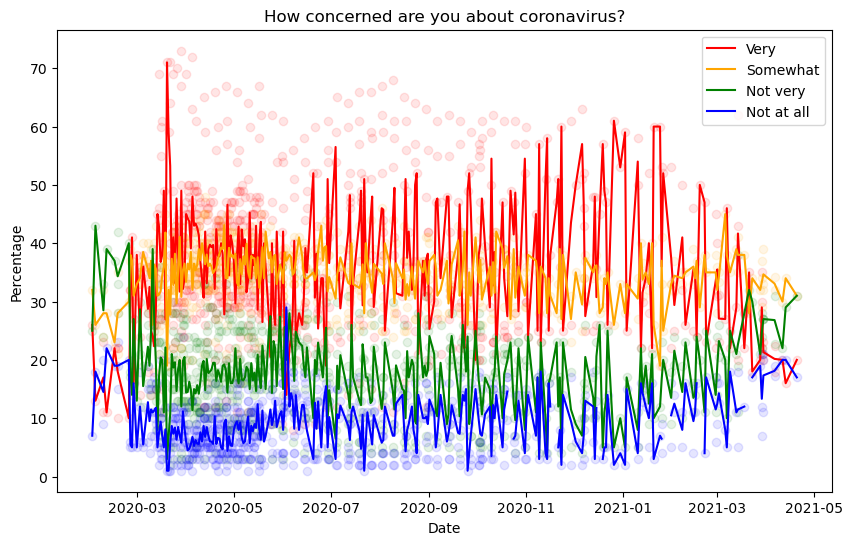

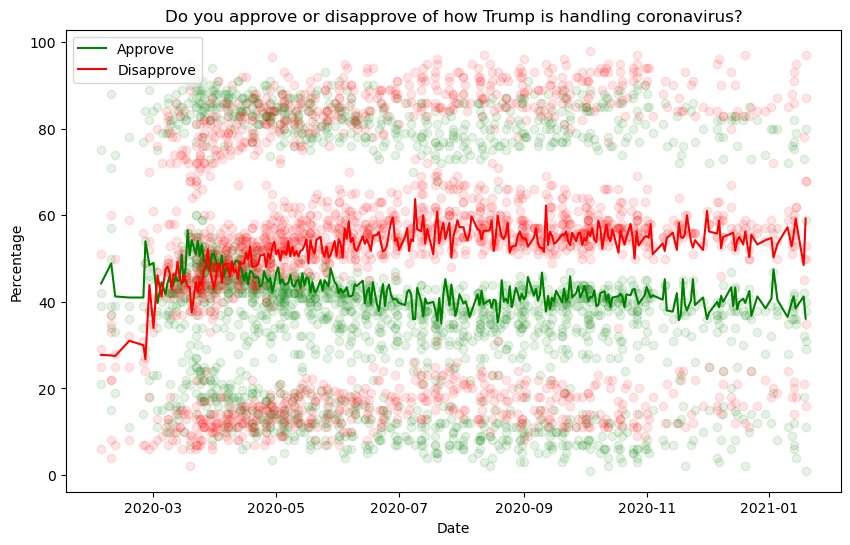

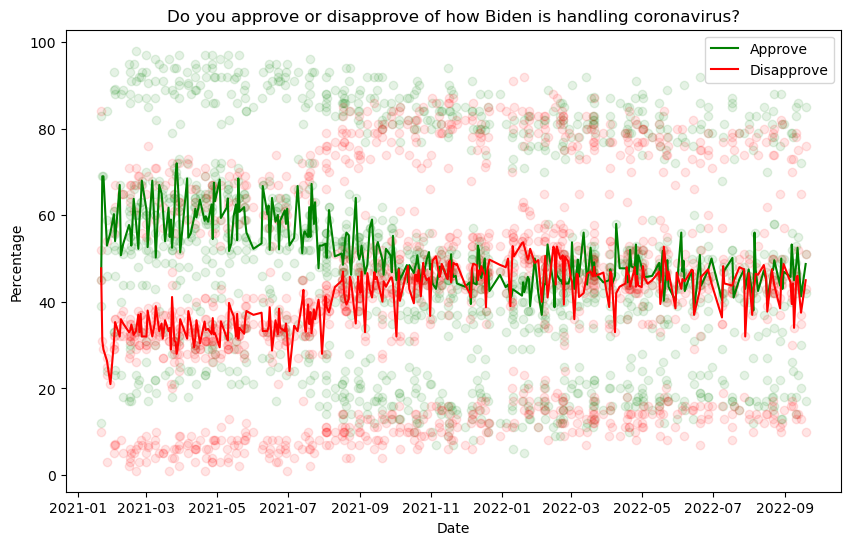

In [12]:
# Read the data from csv files
covid_concern_polls = pd.read_csv('data/covid/covid-19-polls-master/covid_concern_polls.csv')
covid_approval_polls = pd.read_csv('data/covid/covid-19-polls-master/covid_approval_polls.csv')

# Filter the data by date and subject
covid_concern_polls = covid_concern_polls[covid_concern_polls['end_date'] > '2020-02-01']
covid_approval_polls = covid_approval_polls[covid_approval_polls['end_date'] > '2020-02-01']
covid_approval_polls_trump = covid_approval_polls[covid_approval_polls['subject'] == 'Trump']
covid_approval_polls_biden = covid_approval_polls[covid_approval_polls['subject'] == 'Biden']

# Group the data by date
covid_concern_polls_by_date = covid_concern_polls.groupby('end_date').mean()
covid_approval_polls_trump_by_date = covid_approval_polls_trump.groupby('end_date').mean()
covid_approval_polls_biden_by_date = covid_approval_polls_biden.groupby('end_date').mean()

# Convert the date column to datetime format
covid_concern_polls_by_date.index = pd.to_datetime(covid_concern_polls_by_date.index)
covid_approval_polls_trump_by_date.index = pd.to_datetime(covid_approval_polls_trump_by_date.index)
covid_approval_polls_biden_by_date.index = pd.to_datetime(covid_approval_polls_biden_by_date.index)

# Plot the first graph: How concerned are you about coronavirus?
plt.figure(figsize=(10, 6))
plt.plot(covid_concern_polls_by_date.index, covid_concern_polls_by_date['very'], color='red', label='Very')
plt.plot(covid_concern_polls_by_date.index, covid_concern_polls_by_date['somewhat'], color='orange', label='Somewhat')
plt.plot(covid_concern_polls_by_date.index, covid_concern_polls_by_date['not_very'], color='green', label='Not very')
plt.plot(covid_concern_polls_by_date.index, covid_concern_polls_by_date['not_at_all'], color='blue', label='Not at all')
plt.scatter(covid_concern_polls['end_date'], covid_concern_polls['very'], color='red', alpha=0.1)
plt.scatter(covid_concern_polls['end_date'], covid_concern_polls['somewhat'], color='orange', alpha=0.1)
plt.scatter(covid_concern_polls['end_date'], covid_concern_polls['not_very'], color='green', alpha=0.1)
plt.scatter(covid_concern_polls['end_date'], covid_concern_polls['not_at_all'], color='blue', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('How concerned are you about coronavirus?')
plt.legend()
plt.show()

# Plot the second graph: Do you approve or disapprove of how Trump is handling coronavirus?
plt.figure(figsize=(10, 6))
plt.plot(covid_approval_polls_trump_by_date.index, covid_approval_polls_trump_by_date['approve'], color='green', label='Approve')
plt.plot(covid_approval_polls_trump_by_date.index, covid_approval_polls_trump_by_date['disapprove'], color='red', label='Disapprove')
plt.scatter(covid_approval_polls_trump['end_date'], covid_approval_polls_trump['approve'], color='green', alpha=0.1)
plt.scatter(covid_approval_polls_trump['end_date'], covid_approval_polls_trump['disapprove'], color='red', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('Do you approve or disapprove of how Trump is handling coronavirus?')
plt.legend()
plt.show()

# Plot the third graph: Do you approve or disapprove of how biden is handling coronavirus?
plt.figure(figsize=(10, 6))
plt.plot(covid_approval_polls_biden_by_date.index, covid_approval_polls_biden_by_date['approve'], color='green', label='Approve')
plt.plot(covid_approval_polls_biden_by_date.index, covid_approval_polls_biden_by_date['disapprove'], color='red', label='Disapprove')
plt.scatter(covid_approval_polls_biden['end_date'], covid_approval_polls_biden['approve'], color='green', alpha=0.1)
plt.scatter(covid_approval_polls_biden['end_date'], covid_approval_polls_biden['disapprove'], color='red', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('Do you approve or disapprove of how Biden is handling coronavirus?')
plt.legend()
plt.show()


<Figure size 1000x600 with 0 Axes>

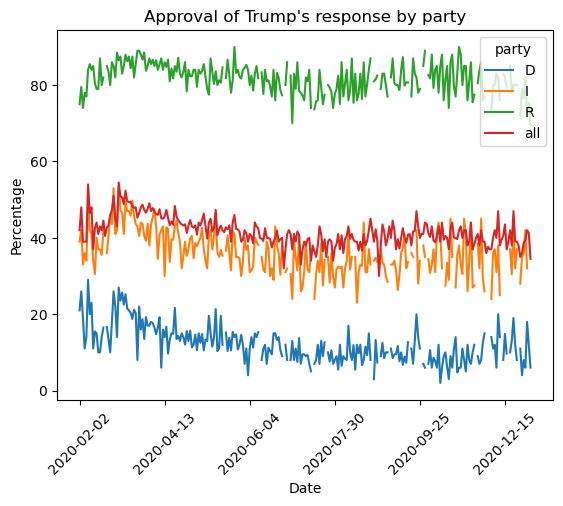

<Figure size 1000x600 with 0 Axes>

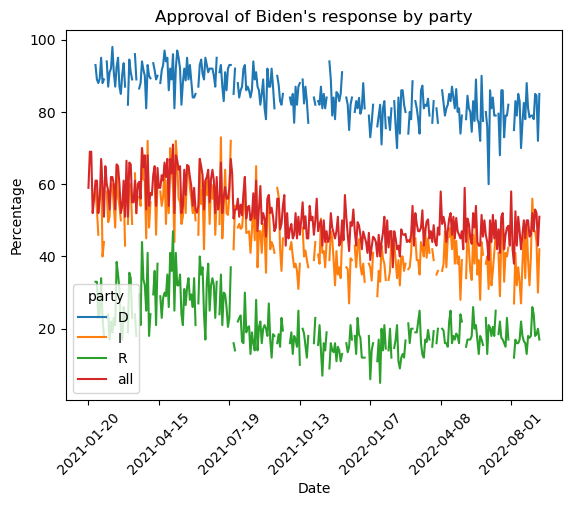

In [18]:
# Read the csv file
covid_approval_polls = pd.read_csv('data/covid/covid-19-polls-master/covid_approval_polls.csv')

# Filter the dataframe by subject
trump_polls = covid_approval_polls[covid_approval_polls["subject"] == "Trump"]
biden_polls = covid_approval_polls[covid_approval_polls["subject"] == "Biden"]

# Group by party and start_date and calculate the mean of approve
trump_polls_grouped = trump_polls.groupby(["party", "start_date"])["approve"].mean()
biden_polls_grouped = biden_polls.groupby(["party", "start_date"])["approve"].mean()

# Plot the line graphs
plt.figure(figsize=(10, 6))
trump_polls_grouped.unstack(level=0).plot(kind="line", title="Approval of Trump's response by party")
plt.xlabel("Date")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
biden_polls_grouped.unstack(level=0).plot(kind="line", title="Approval of Biden's response by party")
plt.xlabel("Date")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.show()

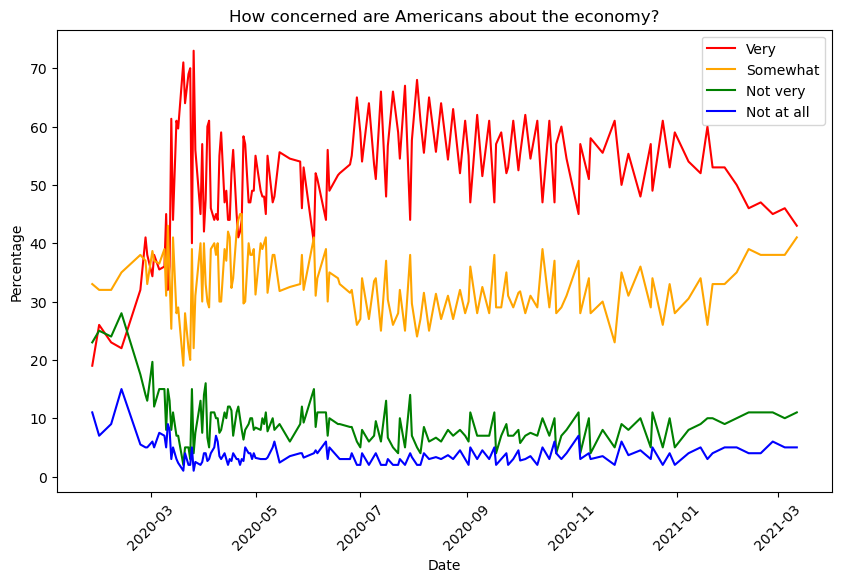

In [16]:
# Read the csv file
covid_concern_polls = pd.read_csv("data/covid/covid-19-polls-master/covid_concern_polls.csv")

# Filter the dataframe by subject
economy_polls = covid_concern_polls[covid_concern_polls["subject"] == "concern-economy"]

# Convert the start_date column to a datetime object
economy_polls["start_date"] = pd.to_datetime(economy_polls["start_date"])

# Group by start_date and calculate the mean of the levels of concern
economy_polls_grouped = economy_polls.groupby("start_date")[["very", "somewhat", "not_very", "not_at_all"]].mean()

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(economy_polls_grouped.index, economy_polls_grouped['very'], color='red', label='Very')
plt.plot(economy_polls_grouped.index, economy_polls_grouped['somewhat'], color='orange', label='Somewhat')
plt.plot(economy_polls_grouped.index, economy_polls_grouped['not_very'], color='green', label='Not very')
plt.plot(economy_polls_grouped.index, economy_polls_grouped['not_at_all'], color='blue', label='Not at all')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('How concerned are Americans about the economy?')
plt.legend()
plt.xticks(rotation=45)
plt.show()

The provided code is related to the analysis and visualization of poll data on various aspects of the COVID-19 pandemic in the United States. Here's an explanation of the approach and assumptions made in the code:

1. Data Loading:
   - The code begins by loading two CSV files into Pandas DataFrames: `covid_concern_polls` and `covid_approval_polls`. These files contain poll data related to COVID-19 concerns and approval ratings for handling the pandemic.

2. Data Filtering:
   - Data filtering is performed to focus on relevant time periods and subjects.
   - For both DataFrames, the data is filtered to include records with an 'end_date' after February 1, 2020. This ensures that only data from February 2020 onwards is considered.
   - In the case of approval polls, the code further filters the data into two DataFrames: `covid_approval_polls_trump` and `covid_approval_polls_biden`. These DataFrames contain data specifically related to approval ratings for Trump and Biden.
   - For concern polls, specific subjects are not filtered as they are likely different aspects of COVID-19 concern.

3. Grouping Data:
   - The code groups the filtered DataFrames by the 'end_date' (for concern polls) and 'start_date' (for approval polls) and calculates the mean values for the different poll categories. This is done using the `groupby` and `mean` functions.

4. Date Formatting:
   - The date columns in the grouped DataFrames are converted to the datetime format to ensure proper date-based plotting and analysis.

5. Plotting:
   - Three different graphs are created using Matplotlib:
     a. COVID-19 Concern Over Time:
        - The first graph visualizes the level of concern about coronavirus over time. It plots the percentage of responses in different categories ("very," "somewhat," "not very," "not at all") as line graphs and uses scatter points to show the raw data.
        - Different colors are used to distinguish the levels of concern.
        - The graph also has labels, a title, and a legend for clarity.

     b. Trump's Handling of Coronavirus Approval:
        - The second graph displays the approval and disapproval ratings for how Trump is handling coronavirus over time.
        - It uses green for "approve" and red for "disapprove."
        - Scatter points are used to visualize raw data.
        - The graph includes labels, a title, and a legend.

     c. Biden's Handling of Coronavirus Approval:
        - The third graph is similar to the second one but focuses on Biden's handling of coronavirus.

6. Additional Analysis:
   - After the first set of plots, the code loads the same approval poll data and conducts further analysis.
   - It groups the data by political party and date, calculating the mean approval ratings for Trump and Biden. The code then creates two line graphs to visualize how approval ratings vary by party and over time.

   - The code also analyzes COVID-19 concern related to the economy. It filters the data by the "concern-economy" subject, converts date columns to datetime, groups the data, and creates a line graph to visualize the level of concern about the economy over time.

Other Assumptions:
- It assumes that the date columns in the input data are in a format that can be directly converted to datetime.
- The code assumes that the input data is reliable and does not perform data validation or error handling.

